# Exploring the Anomalies

In [1]:
### Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors

import ipyleaflet as ipy

from pyspark import SparkContext
import pyspark.sql.functions as F
import pyspark.ml.functions as M
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql import Window as W
from pyspark.sql.types import *
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.stat import Correlation

import time
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

Matplotlib created a temporary cache directory at /tmp/matplotlib-ichbbodd because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
### Notes from prof's example notebook
# #Make sure you allocate enough memory per core. if you chose 3 cores you should select 6GB in your per Node setting. (presumably 2GB per core)

### For server
# 32 nodes
# 64g

## Start Spark context
total_nodes = 8
memory_per_node = 64

driver_memory = f"{memory_per_node}g"
executor_memory = f"{int(memory_per_node/total_nodes)}g"
n_executors = total_nodes - 1
print(f"Driver memory: {driver_memory}\nExecutor memory: {executor_memory}\nNumber of executors: {n_executors}\n")
try:
    print("Initializing SparkContext")
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .getOrCreate()
    
                             # .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
                             # .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
except:
    print("Starting new SparkContext")
    sc.stop()
    sc = SparkSession.builder.config("spark.driver.memory", driver_memory) \
                             .config("spark.executor.memory", executor_memory) \
                             .config('spark.local.dir', "test_dir/") \
                             .config("spark.driver.maxResultSize", "16g") \
                             .config("spark.executor.instances", n_executors) \
                             .appName("MyApp") \
                             .config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.9.4") \
                             .config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
                             .getOrCreate()
print(sc)

# Start SQL Context
sqlContext = SQLContext(sc)

# Add sc parameters
sc.getActiveSession()
# sc.builder.appName("Read CSV").getOrCreate()
# sc.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

Driver memory: 64g
Executor memory: 8g
Number of executors: 7

Initializing SparkContext


/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
%%time
### Load datasets

### Open the outlier datasets
pca_major = pd.read_csv("outliers/0_pca_major_outliers.csv", index_col=0)
pca_close = pd.read_csv("outliers/1_pca_close_outliers.csv", index_col=0)
iqr_outliers = pd.read_csv("outliers/2_IQR_outliers.csv", index_col=0)
std_outliers = pd.read_csv("outliers/3_STD_outliers.csv", index_col=0)
iforest_outliers = pd.read_csv("outliers/4_iforest_outliers.csv", index_col=0)

### For IQR and STD ONLY: Filter for only the low PC1 or PC2 outliers since those were most significant for both
iqr_outliers = iqr_outliers[(iqr_outliers["IQR_PC1_low"]==1) | (iqr_outliers["IQR_PC2_low"]==1)]
std_outliers = std_outliers[(std_outliers["STD_PC1_low"]==1) | (std_outliers["STD_PC2_low"]==1)]

### Filter the metadata for only the correct kwp systems
meta_filename = "metadata_preprocessed.csv"
df_meta = pd.read_csv(meta_filename)

high_kwp_cutoff = df_meta["kwp"].quantile(0.75)
low_kwp_cutoff = df_meta["kwp"].quantile(0.25)

df_meta = df_meta[(df_meta["kwp"]>low_kwp_cutoff) & (df_meta["kwp"]<high_kwp_cutoff)].reset_index(drop=True)

df_meta.describe()

CPU times: user 426 ms, sys: 60.7 ms, total: 487 ms
Wall time: 489 ms


,ss_id,latitude_rounded,longitude_rounded,orientation,tilt,kwp
count,11917.000000,11917.000000,11917.000000,11917.000000,11917.000000,11917.000000
mean,14622.054880,52.881305,-1.415430,178.305782,31.594025,2.809018
std,6761.647032,1.454569,1.358153,47.652603,5.790324,0.303699
min,2405.000000,50.100000,-5.680000,0.000000,5.000000,2.289000
25%,9387.000000,51.890000,-2.390000,150.000000,30.000000,2.520000
50%,14451.000000,52.600000,-1.480000,180.000000,30.000000,2.800000
75%,19706.000000,53.480000,-0.260000,210.000000,35.000000,3.060000
max,26768.000000,58.150000,1.720000,350.000000,60.000000,3.400000


In [4]:
pca_major_meta = pd.merge(pca_major[["id", "ss_id", "stamp_date"]], df_meta, how="inner", on="ss_id")
pca_close_meta = pd.merge(pca_close, df_meta, how="inner", on="ss_id")
pca_outliers_meta = pd.concat([pca_major_meta, pca_close_meta], axis=0).reset_index(drop=True)

iqr_outliers_meta = pd.merge(iqr_outliers, df_meta, how="inner", on="ss_id")
std_outliers_meta = pd.merge(std_outliers, df_meta, how="inner", on="ss_id")

iforest_outliers_meta = pd.merge(iforest_outliers, df_meta, how="inner", on="ss_id")

In [5]:
### Split iforest_outliers_meta into close and major
# Calculate Q1 - 1.5 * IQR
Q1 = iforest_outliers_meta["score"].quantile(0.25)
Q3 = iforest_outliers_meta["score"].quantile(0.75)
cutoff = Q1 - 1.5 * (Q3-Q1)
print(cutoff)

iforest_close_meta = iforest_outliers_meta[iforest_outliers_meta["score"] >= cutoff]
iforest_major_meta = iforest_outliers_meta[iforest_outliers_meta["score"] < cutoff]

0.7462180000000003


In [6]:
### Set up function to plot histograms
def plot_hist(plot_df):
    # Setting up the gridspec subplots
    fig = plt.figure(figsize=(12,10))
    grid = plt.GridSpec(3,4, wspace=0.45, hspace=0.35)
    
    plot1 = fig.add_subplot(grid[0,1:3])
    plot2 = fig.add_subplot(grid[1,:2])
    plot3 = fig.add_subplot(grid[1,2:])
    plot4 = fig.add_subplot(grid[2,:2])
    plot5 = fig.add_subplot(grid[2,2:])
    
    plots = [plot1, plot2, plot3, plot4, plot5]
    cols = ["kwp", "latitude_rounded", "longitude_rounded", "orientation", "tilt"]
    titles = ["PV System Power Rating", "Latitude", "Longitude", "Panel Orientation", "Panel Tilt"]
    colors = ["r", "b", "g", "orange", "pink"]
    
    for i,(ax,col,title, color) in enumerate(zip(plots, cols, titles, colors)):
        sns.histplot(plot_df[col], ax=ax, bins=50, color=color)
        ax.set(xlabel="", title=title)

    return plots

def plot_hist2(plot_dfs, col, titles):
    ### Same as before, except show the result for several dfs on a single column
    # Setting up the gridspec subplots
    fig = plt.figure(figsize=(12,9))
    grid = plt.GridSpec(4,4, wspace=0.55, hspace=0.35, top=0.9)
    
    plot1 = fig.add_subplot(grid[0,1:3])
    plot2 = fig.add_subplot(grid[1,:2])
    plot3 = fig.add_subplot(grid[1,2:])
    plot4 = fig.add_subplot(grid[2,:2])
    plot5 = fig.add_subplot(grid[2,2:])
    # plot6 = fig.add_subplot(grid[3,:2])
    # plot7 = fig.add_subplot(grid[3,2:])
    
    plots = [plot1, plot2, plot3, plot4, plot5]#, plot6, plot7]
    colors = ["r", "b", "g", "orange", "pink"]#, "c", "brown"]
    
    for i,(ax, plot_df, title, color) in enumerate(zip(plots, plot_dfs, titles, colors)):
        sns.histplot(plot_df[col], ax=ax, bins=50, color=color)
        ax.set(xlabel="", title=title)

    return plots

In [13]:
### Gather the variables together
plot_dfs = [df_meta, pca_outliers_meta, 
            iqr_outliers_meta, std_outliers_meta, 
            iforest_major_meta]
titles = ["All Systems", "PCA Only", 
          "IQR Method (Low PC1/PC2 Only)",
          "STD Method (Low PC1/PC2 Only)",
          f"I-Forest (Score < {np.round(cutoff, 3)})"]

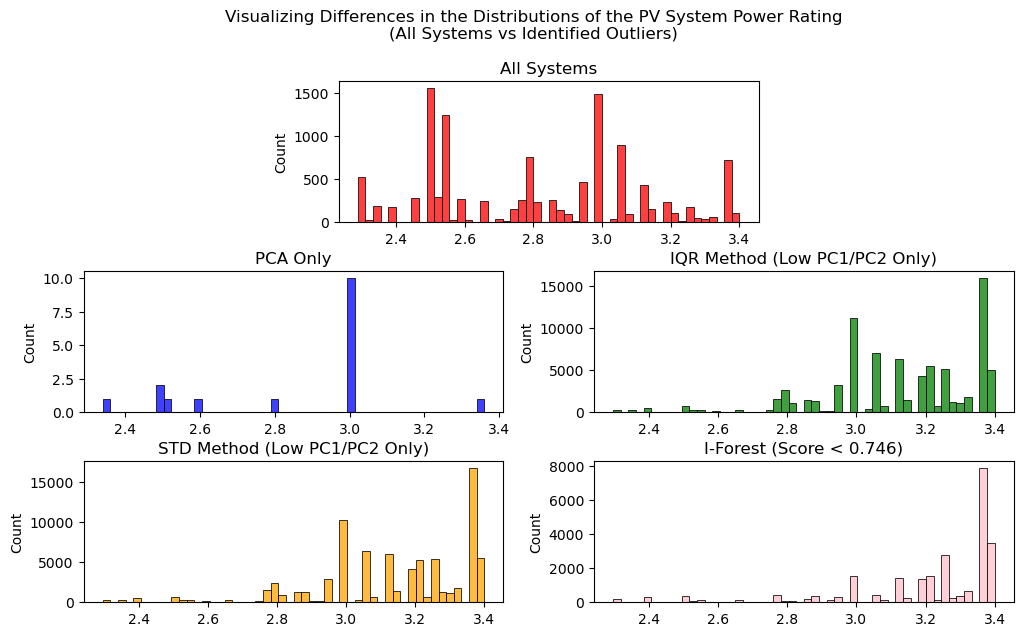

In [14]:
### Plotting histograms for each outlier group
col = "kwp"
col_title = "PV System Power Rating"
plot_hist2(plot_dfs, col, titles)
plt.suptitle(f"Visualizing Differences in the Distributions of the {col_title}\n(All Systems vs Identified Outliers)")
plt.show()

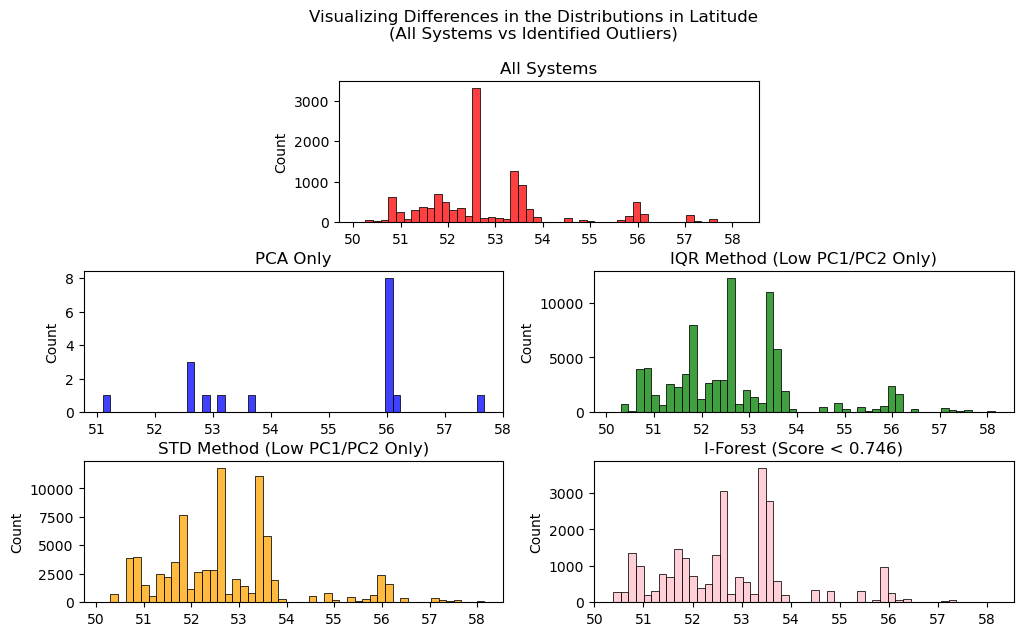

In [15]:
### Plotting histograms for each outlier group
col = "latitude_rounded"
col_title = "Latitude"
plot_hist2(plot_dfs, col, titles)
plt.suptitle(f"Visualizing Differences in the Distributions in {col_title}\n(All Systems vs Identified Outliers)")
plt.show()

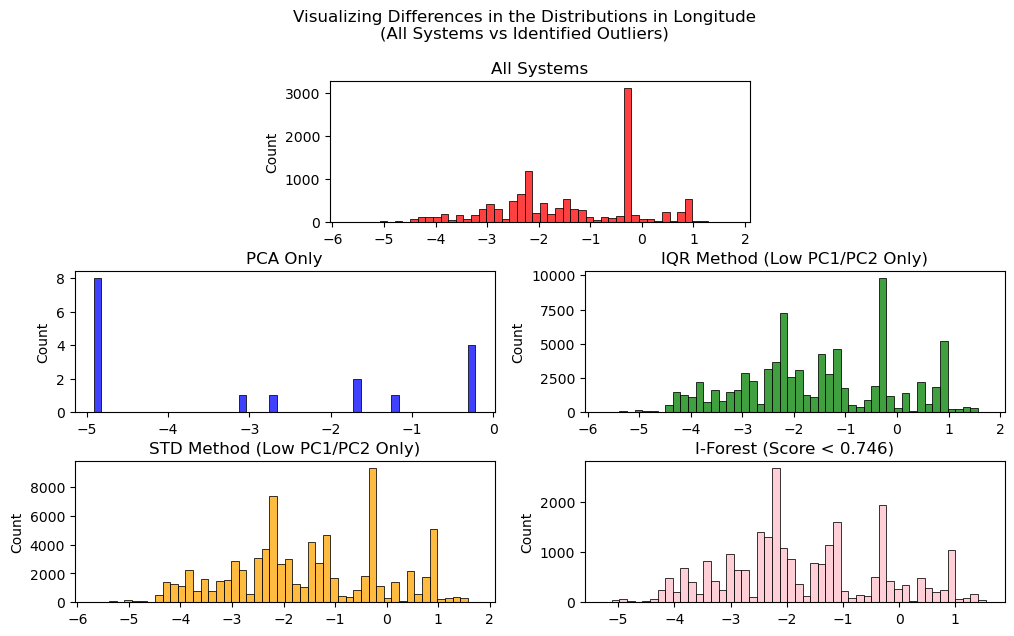

In [16]:
### Plotting histograms for each outlier group
col = "longitude_rounded"
col_title = "Longitude"
plot_hist2(plot_dfs, col, titles)
plt.suptitle(f"Visualizing Differences in the Distributions in {col_title}\n(All Systems vs Identified Outliers)")
plt.show()

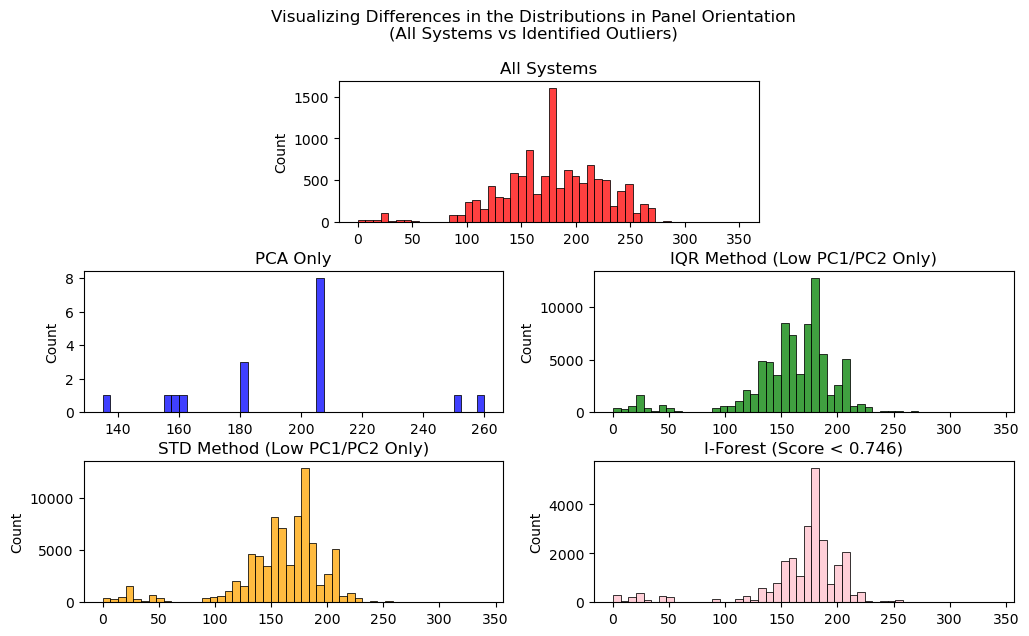

In [17]:
### Plotting histograms for each outlier group --> pca outliers
col = "orientation"
col_title = "Panel Orientation"
plot_hist2(plot_dfs, col, titles)
plt.suptitle(f"Visualizing Differences in the Distributions in {col_title}\n(All Systems vs Identified Outliers)")
plt.show()

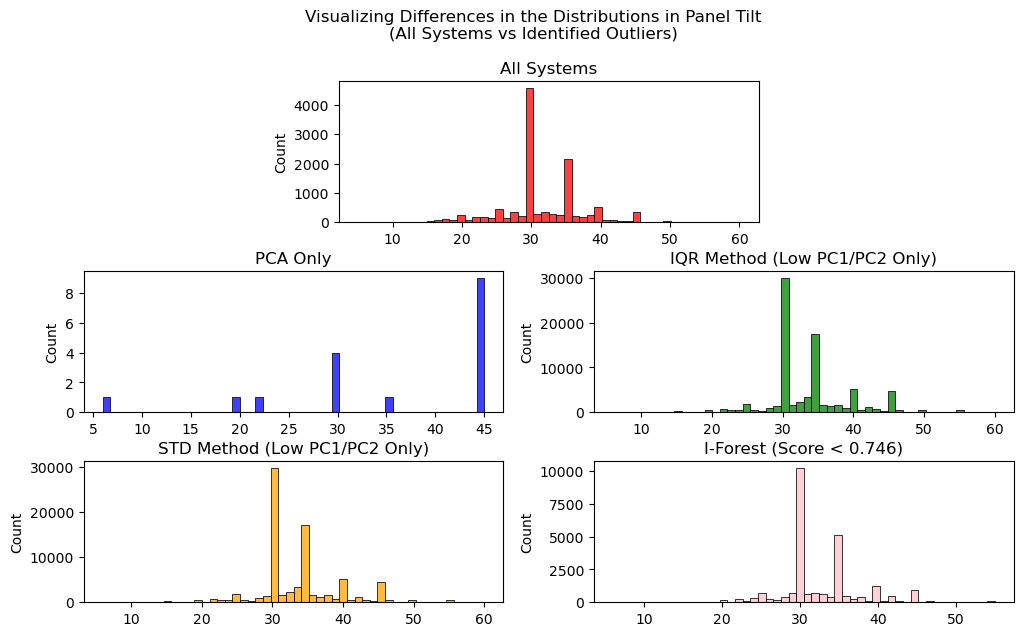

In [18]:
### Plotting histograms for each outlier group --> pca outliers
col = "tilt"
col_title = "Panel Tilt"
plot_hist2(plot_dfs, col, titles)
plt.suptitle(f"Visualizing Differences in the Distributions in {col_title}\n(All Systems vs Identified Outliers)")
plt.show()